In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount('/content/drive')

Mounted at /content/drive


# Part I) Warming up: birth-death process

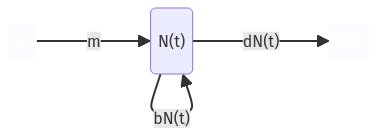

In [ ]:
cv2_imshow(cv2.imread("/content/drive/MyDrive/MOCS 2024/birth-death.png", -1 ))


We start with the **recursion equation**:
$$N(t+1) = N(t) + \Delta N$$

That is, the population at next time step is the current population plus the expected change in the population, aka $ \Delta N $. How do we come up with change in $N$? This is where the diagram comes handy; we can see that population at next time step is the reproduction ($bN(t)$), minus the outflow (constant rate $dN(t)$), plus some constant inflow ($m$).

\begin{equation}
  \begin{split}
    \Delta N &= N(t+1) - N(t) \\
            &= N(t) + (b - d)N(t) + m - N(t) \\
            &= (b - d)N(t) + m
  \end{split}
\end{equation}

This is called a [difference equation](https://math.libretexts.org/Bookshelves/Scientific_Computing_Simulations_and_Modeling/Introduction_to_the_Modeling_and_Analysis_of_Complex_Systems_(Sayama)/04%3A_DiscreteTime_Models_I__Modeling/401%3A_DiscreteTime_Models_with_Difference_Equations). See also [Smaldino section 4.2.2](https://github.com/jstonge/2024Fall-MOCS/blob/main/docs/readings/Smaldino-2023-ch4.pdf) for a more detailed explanation.


In [ ]:
# (I)nitialization

N0 = 100
N = N0

m = 1/2 # inflow
d = 1/4 # outflow
b = 1/3 # repro

res = [] # list of results

#  Observe & Update
T_max = 30 # days
for t in range(T_max): # here we are assuming days
	delta_N = (b - d)*N + m  # ΔN = N(t+1) - N(t) = N(t) + (b - d)N(t) + m - N(t) = (b - d)N(t) + m
	N += delta_N             # N(n+1) = N(t) + ΔN
	res.append(N)

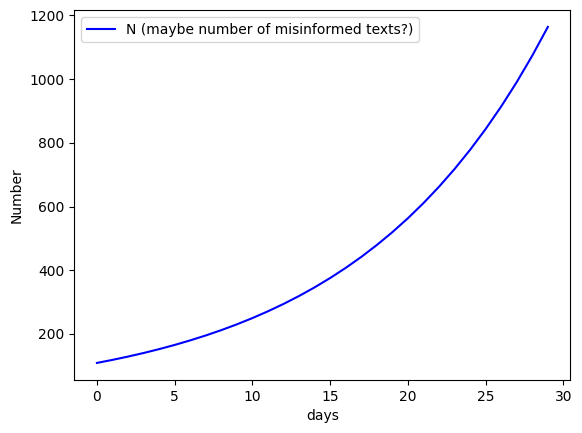

In [ ]:
#plot results
fig,ax = plt.subplots()
ax.plot(res, 'b', label='N (maybe number of misinformed texts?)')
plt.xlabel("days")
plt.ylabel("Number")
ax.legend();

# Part II) SIR model

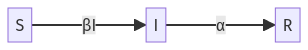

In [ ]:
cv2_imshow(cv2.imread("/content/drive/MyDrive/MOCS 2024/sir.png", -1 ))

There are two ways to understand the diagram above that give different intuitions about the problem.

### _Version 1: fully-connected_


Version 1 focuses on what happens when we assume that everyone is connected to everyone. When we say there are 10 times more infected people, we should expect 10 times more people getting infected.

One way (LHD's way) is to think about what happens when we have 5 options for dinner and as many options of movies to watch. There are 5 x 5 potential pairs, as we know from probability. In the SIR model, we can think of that as the probability that each susceptible individual avoids infection from all infected individuals.

### _Version 2: well-mixed population_

In [ ]:
# initialization

N = 10000 #population
I0 = 1 #patient zero
R0 = 0 #no previous immunity
S0 = N - I0 - R0 #N is a conserved quantity

# parameters

contact_per_day = 5
transmission_time_per_contact = 30
recovery_period = 15

beta = (1/transmission_time_per_contact) * contact_per_day * (1/N) #transmission time per contact: 30 days. contacts per day: 5
alpha = 1/recovery_period #recovery period: 15 days

In [ ]:
S = S0; I = I0; R = R0 #set initial conditions

Version 2 introduces a different way of thinking: contacts are made at random.  The arrow from $S \to I$ focuses on the expected number of contacts on a given day, multiplied by the probability of transmission. We ask: what fraction of the contacts are infectious?

<!-- Where the k arugments should be: does each S there are k connections such that S*k*I/N connections S->I exist? Here we are simply changing units of beta, but its value in b'=b*k/N. Here it is the same in the mean-field limit as we don't follow correlation among agents...-->

\begin{equation}
  \begin{split}
    S(t+1) &= -S(t) (1-(1-\beta)^{I(t)}) \\
    I(t+1) &= S(t) (1-(1-\beta)^{I(t)}) - \gamma I(t) \\
    R(t+1) &= \gamma I(t)
  \end{split}
\end{equation}


The second arrow is about the decreases in the expected number of already-infected individuals who "recover". We don't need to put the fraction here.

With code, we can be super explicit about the meaning of each quantity:

In [ ]:
people_infected = 2000
people_suceptible = N - people_infected
prob_not_getting_infected = 1-beta
prob_getting_infected = 1 - prob_not_getting_infected**(people_infected)
people_suceptible - people_suceptible*prob_getting_infected # 'who remains'

7737.726654463379

### Coding up the well-mixed version

In [ ]:
res = [] #list of results

for t in range(182):
  delta_S = -S * (1-(1-beta)**(I)) #expected number of new infections
  S += delta_S #S(t+1)
  delta_R = alpha*I #expected number of new recoveries
  I+= -delta_S - delta_R #I(t+1)
  R+= delta_R #R(t+1)
  res.append((S,I,R))

#zip unpacked list of tuples (n-th elements all together)
#map them to arrays

St,It,Rt = map(np.array, zip(*res))

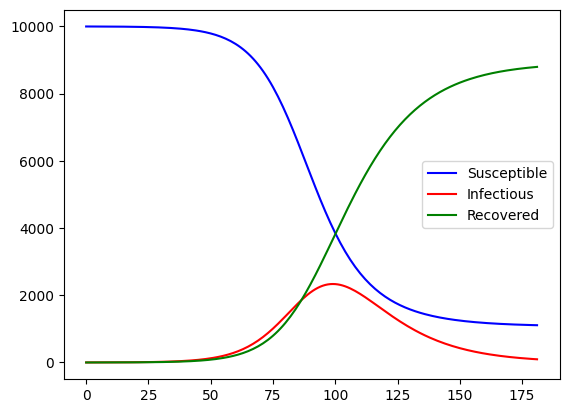

In [ ]:
#plot results
fig,ax = plt.subplots()
ax.plot(St, 'b', label='Susceptible')
ax.plot(It, 'r', label='Infectious')
ax.plot(Rt, 'g', label='Recovered')
ax.legend();

## Our model of the census bureau trying to counteract misinformation

# Lotka-volterra (probably we won't have time)

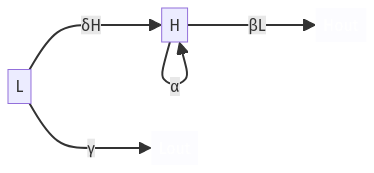

In [ ]:
cv2_imshow(cv2.imread("/content/drive/MyDrive/MOCS 2024/lotka-volterra-1.png", -1 ))

In [ ]:
# initialization
H0 = 10 #initial number of fish
L0 = 5 #initial number of sharks

#parameters
beta = 0.005 #predation rate (shark reproduction)
gamma_l = 0.02 #shark death rate
alpha = 0.05 #fish reproduction rate
delta = 1/10 #conversion factor (shark to fish ratio)

In [ ]:
#discrete steps of Euler's methods

res = [] #list of results
H = H0; L = L0; #set initial conditions

for t in range(182):
  delta_H = alpha*H - H*(1-(1-beta)**L)
  delta_L = delta*H*(1-(1-beta)**L) - gamma_l*L
  H += delta_H #I(t+1)
  L += delta_L #M(t+1)
  res.append((H,L))

Hd,Ld = map(np.array, zip(*res))

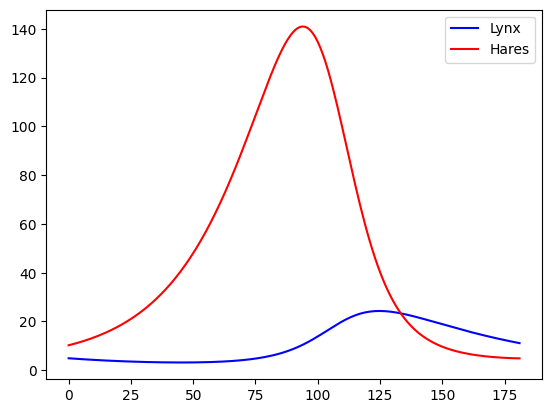

In [ ]:
#plot results
fig,ax = plt.subplots()
ax.plot(Ld, 'b', label='Lynx')
ax.plot(Hd, 'r', label='Hares')
ax.legend();